# Simulation 2: Event width

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import hmp
from itertools import cycle
from scipy import stats
import bambi as bmb 
import pandas as pd
import arviz as az
from itertools import product
from os import listdir
import scipy.optimize as opt
from hmp import simulations


colors = ['royalblue','darkgreen','indianred','goldenrod', 'pink', 'black']

def fit_or_load(filename, path, model):
    if filename not in listdir(path):
        fit = model.fit(inference_method='nuts_numpyro',idata_kwargs={"log_likelihood": True})
        fit.to_netcdf(path+'/'+filename)
    else:
        fit = az.from_netcdf(path+'/'+filename)
    return fit

## Illustration

Processing participant ./event_duration_example_raw.fif's continuous eeg
Reading 0 ... 13090  =      0.000 ...    13.090 secs...


/home/gweindel/miniconda3/envs/hmp2/lib/python3.11/site-packages/hmp/simulations.py:164: UserWarning: ./event_duration_example_raw.fif exists no new simulation performed
  warn(f'{subj_file} exists no new simulation performed', UserWarning)
/home/gweindel/miniconda3/envs/hmp2/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""
/home/gweindel/miniconda3/envs/hmp2/lib/python3.11/site-packages/hmp/utils.py:259: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data_epoch = epochs.get_data()#preserves index
/home/gweindel/miniconda3/envs/hmp2/lib/python3.11/site-packages/hmp/utils.py:657: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeez

1 trials were retained for participant ./event_duration_example_raw.fif


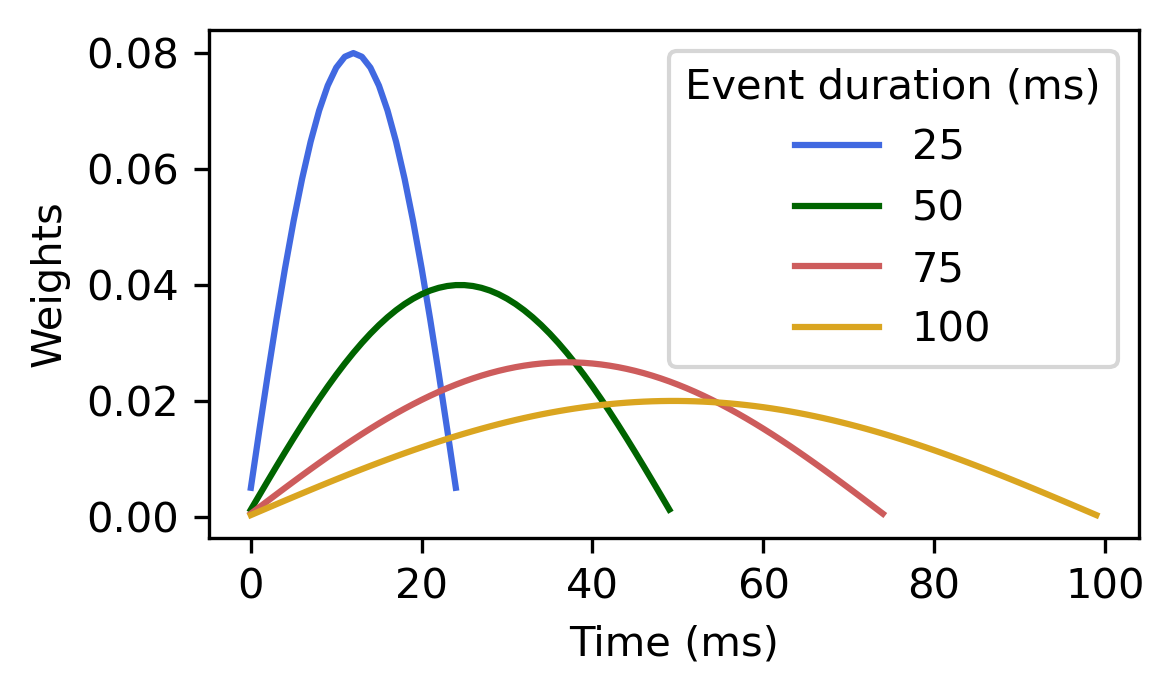

In [2]:
from scipy.stats import gamma
cpus = 2 # For multiprocessing, usually a good idea to use multiple CPUs as long as you have enough RAM

n_trials = 1 #Number of trials to simulate
sfreq = 1000
##### Here we define the sources of the brain activity (event) for each trial
Nevents = 1
frequency = 10. #Frequency of the event defining its duration, half-sine of 10Hz = 50ms
amplitude = 1e-8 #Amplitude of the event in nAm, defining signal to noise ratio
shape = 2 #shape of the gamma distribution
means = np.array([200])/shape #Mean duration of the stages in ms
names = simulations.available_sources()[0] #Which source to activate at each stage (see atlas when calling simulations.available_sources())

sources = []
for source in zip(names, means): #One source = one frequency, one amplitude and a given by-trial variability distribution
    sources.append([source[0], frequency, amplitude, gamma(shape, scale=source[1])])

# Function used to generate the data
file = simulations.simulate(sources, n_trials, cpus, 'event_duration_example', overwrite=False, sfreq=sfreq)

#Recovering the events to epoch the data (in the number of trials defined above)
events = np.load(file[1])
resp_trigger = int(np.max(np.unique(events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':1}#trigger 1 = stimulus
resp_id = {'response':resp_trigger}
#Keeping only stimulus and response triggers

eeg_data = hmp.utils.read_mne_data(file[0], event_id=event_id, resp_id=resp_id, sfreq=sfreq, 
            events_provided=events, verbose=False)

hmp_dat = hmp.utils.transform_data(eeg_data, apply_standard=False, n_comp=4)
init = hmp.models.hmp(hmp_dat, sfreq=eeg_data.sfreq, event_width=50, cpus=cpus)#Initialization of the model

plt.figure(figsize=(4,2.2), dpi=300)

durations = [25,50,75,100]
for i, duration in enumerate(durations):
    init = hmp.models.hmp(hmp_dat, sfreq=eeg_data.sfreq, event_width=duration, cpus=cpus)#Initialization of the model
    plt.plot(init.template, label=duration, color=colors[i])
plt.legend(title='Event duration (ms)')
plt.xlabel('Time (ms)')
plt.ylabel('Weights')
plt.savefig('../../plots/event_duration-illustration.png',dpi=300,transparent=True,bbox_inches='tight')

# plt.savefig('Event_duration-illustration.png', dpi=300)

## Demo

Quite slow because of the simulation (approx. 10 minutes), comment out if you want to run it

In [3]:
# ## Imports and code specific to the simulation (see tutorial 3 and 4 for real data)
# import os
# import mne
# from hmp import simulations
# from scipy.stats import gamma as sp_dist
# from hmp.utils import gamma_scale_to_mean,gamma_mean_to_scale
# scale_to_mean, mean_to_scale = gamma_scale_to_mean,gamma_mean_to_scale


# seed = 0
# source_index = [44, 42, 14, 17]
# rng = np.random.default_rng(seed=seed)#Setting seeed for reproducibility
# true_dur = 50#for example
# true_freq = 1000/true_dur/2
# version = '44b3500'
# cpus = 1 # For multiprocessing, usually a good idea to use multiple CPUs as long as you have enough RAM
# path = os.path.join('simulated/')#Where simulated data will go, create that folder if you don't have it where you're executing the code

# #EEG specific
# info = simulations.simulation_info()
# all_other_chans = range(len(info.ch_names[:-61]))#non-eeg
# chan_list = list(np.arange(len(info.ch_names)))
# chan_list = [e for e in chan_list if e not in all_other_chans]
# chan_list.pop(52)#Bad elec
# info = mne.pick_info(info, sel=chan_list)

# #Fixed simulation parameters
# amplitude = 1e-6

# Nevents = 3
# name_sources = simulations.available_sources()[rng.choice(source_index,Nevents+1, replace=False)]
# n_trials = 100#Number of trials to simulate
# sfreq = 1000
# n_comp = 5
# distribution = 'gamma'
# shape = 2
# #Variable simulation parameters

# durations = [25,50,75,100][::-1]

# all_combinations = list(durations)

# means_list = np.repeat(200,Nevents+1) 
# # Function used to generate the data
# times = mean_to_scale(means_list, shape)
# sources = []
# for source in range(len(name_sources)):
#     sources.append([name_sources[source], true_freq, amplitude, \
#             sp_dist(shape, scale=times[source])])
# file = simulations.simulate(sources, n_trials, cpus, 'demo_var-dur', path=path, 
#                     overwrite=True, sfreq=sfreq, seed=seed)
# #Recover info from simulation
# generating_events = np.load(file[1])
# resp_trigger = int(np.max(np.unique(generating_events[:,2])))#Resp trigger is the last source in each trial
# event_id = {'stimulus':1}#trigger 1 = stimulus
# resp_id = {'response':resp_trigger}#Response is defined as the last trigger in a sequence of events
# #Keeping only stimulus and response triggers
# events = generating_events[(generating_events[:,2] == 1) | (generating_events[:,2] == resp_trigger)]#only retain stimulus and response triggers

# number_of_sources = len(np.unique(generating_events[:,2])[1:])#one trigger = one source
# epoch_data = hmp.utils.read_mne_data(file[0], event_id=event_id, resp_id=resp_id, 
#                 sfreq=sfreq, events_provided=events, verbose=False)
    
# hmp_data = hmp.utils.transform_data(epoch_data, apply_standard=False, n_comp=n_comp)
# fig, ax = plt.subplots(4,1, figsize=(4,4),sharex=True, dpi=300)
# random_source_times, _, _, _ = hmp.simulations.simulated_times_and_parameters(generating_events, init=test_init)

# for i,test_event_width in enumerate(durations):
#     print(test_event_width)
#     # Estimating an HMP model
#     test_init = hmp.models.hmp(hmp_data, sfreq=sfreq, event_width=test_event_width, cpus=cpus, distribution=distribution, shape=shape)#Initialization of the model

#     fit = test_init.fit(verbose=False)
#     hmp.visu.plot_topo_timecourse(epoch_data, fit, info, test_init, magnify=2, ax=ax[i], sensors=False, 
#         times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0), colorbar=False, cmap='Spectral_r')
#     ax[i].set_ylabel('%i ms'%test_event_width)
# ax[i].set_xlabel('Time from stimulus onset (ms)')
# plt.savefig('../../plots/event_duration-demo.png',dpi=300,transparent=True,bbox_inches='tight')
# plt.show()

![](../../plots/event_duration-demo.png)

## Collecting and concatenating results from cluster

In [4]:
from os import listdir

results = []
i = 0 
path = 'simulation_data/event_results/'
for file in listdir(path):
    if 'results' in file:
        r_i = xr.load_dataset(path+file, engine='netcdf4')
        r_i['seed'] = r_i.seed
        results.append(r_i)
        i += 1
results = xr.concat(results, dim='iteration')
results = results.rename({'test_n_events':'TestN', 'gen_dur':'GenWidth', 'test_dur':'TestWidth'})
results.attrs['Nevents'] = results.attrs.pop('n_events')
results['Hit'] = results.hit.count('event')
results['PPV'] = (results['Hit']) / results.TestN
results['TPR'] = (results['Hit']) / results.Nevents
print(f'{len(results.where(np.isnan(results.TPR), drop=True).iteration)} simulations are Nan')
results = results.dropna(dim="iteration", how="any", subset=['TPR'])
Nevents_df = results.groupby('all_combination').mean(('trial','component','stage','event')).to_dataframe().reset_index()
results

0 simulations are Nan


<xarray.Dataset>
Dimensions:           (iteration: 499, event: 3, all_combination: 4,
                       trial: 100, stage: 4, component: 5)
Coordinates:
    GenWidth          (iteration, all_combination) float64 19.51 19.51 ... 57.96
    TestWidth         (all_combination) int64 25 50 75 100
Dimensions without coordinates: iteration, event, all_combination, trial,
                                stage, component
Data variables: (12/14)
    names             (iteration, event) <U21 'isthmuscingulate-rh' ... 'fron...
    TestN             (iteration, all_combination) float64 1.0 0.0 ... 2.0 1.0
    loglikelihood     (iteration, all_combination) float64 -95.35 nan ... -478.8
    time              (iteration, all_combination) float64 116.7 nan ... 74.61
    hit               (iteration, all_combination, event) float64 nan ... nan
    false_alarm       (iteration, all_combination) float64 0.0 nan ... 0.0 0.0
    ...                ...
    gen_mags          (iteration, all_combination, event, component) float64 ...
    recov_mags        (iteration, all_combination, event, component) float64 ...
    seed              (iteration) int64 29 97 264 109 215 ... 125 47 342 132 246
    Hit               (iteration, all_combination) int64 1 0 0 0 3 ... 0 3 3 2 1
    PPV               (iteration, all_combination) float64 1.0 nan ... 1.0 1.0
    TPR               (iteration, all_combination) float64 0.3333 0.0 ... 0.3333
Attributes:
    amplitude:     1e-06
    sfreq:         500
    n_comp:        5
    distribution:  gamma
    shape:         2
    n_trials:      100
    seed:          29
    Nevents:       3

## Modelling TPR and PPV

In [5]:
Nevents_df = results.groupby('all_combination').mean(('trial','component','stage','event')).to_dataframe().reset_index()
Nevents_df['Nevents'] = results.Nevents
Nevents_df['GenWidth'] = 1/(Nevents_df['GenWidth'])#Frequency domain
Nevents_df['TestWidth'] = Nevents_df['TestWidth'].astype('str')#Factor
tpr_model1 = bmb.Model("p(Hit, Nevents) ~ TestWidth * GenWidth", Nevents_df, family="binomial", dropna=True)
tpr_fit1 = fit_or_load('tpr_model_event1.nc', 'bambi_fits/',tpr_model1)
ppv_model1 = bmb.Model("p(Hit, TestN) ~TestWidth * GenWidth", Nevents_df, family="binomial" , dropna=True)
ppv_fit1 = fit_or_load('ppv_model_event1.nc', 'bambi_fits/', ppv_model1)

In [6]:
tpr_model2 = bmb.Model("p(Hit, Nevents) ~ TestWidth * bs(GenWidth, 2, degree=2)", Nevents_df, family="binomial", dropna=True)
tpr_fit2 = fit_or_load('tpr_model_event2.nc', 'bambi_fits/',tpr_model2)
ppv_model2 = bmb.Model("p(Hit, TestN) ~TestWidth * bs(GenWidth, 2, degree=2)", Nevents_df, family="binomial" , dropna=True)
ppv_fit2 = fit_or_load('ppv_model_event2.nc', 'bambi_fits/', ppv_model2)

In [7]:
tpr_model3 = bmb.Model("p(Hit, Nevents) ~ TestWidth * bs(GenWidth, 3, degree=3)", Nevents_df, family="binomial", dropna=True)
tpr_fit3 = fit_or_load('tpr_model_event3.nc', 'bambi_fits/',tpr_model3)
ppv_model3 = bmb.Model("p(Hit, TestN) ~TestWidth * bs(GenWidth, 3, degree=3)", Nevents_df, family="binomial" , dropna=True)
ppv_fit3 = fit_or_load('ppv_model_event3.nc', 'bambi_fits/', ppv_model3)

## Compare polynomial models

In [8]:
compare_dict = {"linear": tpr_fit1, "squared": tpr_fit2, "cubic": tpr_fit3}

az.compare(compare_dict, ic='waic')

/home/gweindel/miniconda3/envs/hmp2/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/home/gweindel/miniconda3/envs/hmp2/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
cubic,0,-1749.977403,12.428130,0.000000,1.000000e+00,25.466571,0.000000,False,log
squared,1,-1767.182641,10.471589,17.205238,1.515123e-09,24.892440,5.766571,False,log
linear,2,-1942.079425,7.578428,192.102022,0.000000e+00,23.789546,16.812158,False,log


## Generating predictions for plotting

In [9]:
tpr_fit, tpr_model = tpr_fit3, tpr_model3
ppv_fit, ppv_model = ppv_fit3, ppv_model3

In [10]:
GenWidth = np.linspace(Nevents_df.GenWidth.min(), Nevents_df.GenWidth.max(),  num=200)
TestWidth = Nevents_df.TestWidth.unique()

new_data = pd.DataFrame({
    "GenWidth": np.tile(GenWidth, len(TestWidth)),
    "TestWidth": np.repeat(TestWidth, len(GenWidth))
})

tpr_model.predict(tpr_fit, data=new_data)
tpr_posterior = az.extract(tpr_fit, num_samples=2000)['p(Hit, Nevents)_mean']

ppv_model.predict(ppv_fit, data=new_data)
ppv_posterior = az.extract(ppv_fit, num_samples=2000)['p(Hit, TestN)_mean']

For this simulation we use the predictions from the GLM to infer on the effects of the parameters

In [11]:
analysis = new_data.copy()
analysis['GenWidth'] = 1/analysis['GenWidth']
analysis['mean'] = tpr_posterior.mean('sample')
analysis['std'] = tpr_posterior.std('sample')

In [12]:
analysis.groupby(['TestWidth']).mean()

,GenWidth,mean,std
TestWidth,,,
100,32.840289,0.117140,0.006806
25,32.840289,0.839736,0.039397
50,32.840289,0.381972,0.020193
75,32.840289,0.208000,0.010547


In [13]:
analysis.iloc[analysis.groupby(['TestWidth'])['mean'].idxmax().values]

,GenWidth,TestWidth,mean,std
612,95.299772,100,0.725115,0.018011
45,39.110465,25,0.951146,0.010322
241,42.120723,50,0.889151,0.016978
422,66.394417,75,0.855715,0.016199


In [14]:
for test in analysis.TestWidth.unique():
    print(test)
    print(analysis.loc[(analysis.TestWidth == test) & (analysis['mean'] >.5)].GenWidth.min())
    print(analysis.loc[(analysis.TestWidth == '100') & (analysis['mean'] >.5)].GenWidth.max())

25
10.425303601739865
199.5513629532003
50
22.5740535488716
199.5513629532003
75
37.12077208869757
199.5513629532003
100
57.651312565456095
199.5513629532003


In [15]:
for test in analysis.TestWidth.unique():
    print(test)
    print(analysis.loc[(analysis.TestWidth == test) & (analysis['mean'] >.5)].GenWidth.min())
    print(analysis.loc[(analysis.TestWidth == '100') & (analysis['mean'] >.5)].GenWidth.max())

25
10.425303601739865
199.5513629532003
50
22.5740535488716
199.5513629532003
75
37.12077208869757
199.5513629532003
100
57.651312565456095
199.5513629532003


In [16]:
analysis = new_data.copy()
analysis['GenWidth'] = 1/analysis['GenWidth']
analysis['mean'] = ppv_posterior.mean('sample')

In [17]:
analysis.groupby(['TestWidth']).mean()

,GenWidth,mean
TestWidth,,
100,32.840289,0.179506
25,32.840289,0.800952
50,32.840289,0.394753
75,32.840289,0.247355


In [18]:
analysis.iloc[analysis.groupby(['TestWidth'])['mean'].idxmax().values]

,GenWidth,TestWidth,mean
610,104.389102,100,0.977985
168,12.231110,25,0.998081
261,30.415578,50,0.969910
426,59.210738,75,0.942370


In [19]:
for test in analysis.TestWidth.unique():
    print(test)
    print(analysis.loc[(analysis.TestWidth == test) & (analysis['mean'] >.5)].GenWidth.min())
    print(analysis.loc[(analysis.TestWidth == test) & (analysis['mean'] >.5)].GenWidth.max())

25
10.425303601739865
43.80657730964373
50
21.054201694688274
109.61650575063723
75
33.69263546433297
199.5513629532003
100
46.6045521405232
199.5513629532003


In [20]:
az.summary(tpr_fit, hdi_prob=.95, var_names=list(list(tpr_fit.posterior.data_vars.keys()))[:-1])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.358,0.107,0.157,0.572,0.003,0.002,1415.0,2558.0,1.0
TestWidth[25],0.969,0.155,0.677,1.283,0.003,0.002,2076.0,2490.0,1.0
TestWidth[50],0.592,0.153,0.282,0.882,0.004,0.003,1748.0,2488.0,1.0
TestWidth[75],0.122,0.150,-0.186,0.397,0.004,0.003,1677.0,2631.0,1.0
"bs(GenWidth, 3, degree=3)[0]",6.970,1.289,4.427,9.408,0.041,0.029,973.0,1775.0,1.0
"bs(GenWidth, 3, degree=3)[1]",-48.261,6.365,-60.878,-35.963,0.196,0.138,1057.0,1507.0,1.0
"bs(GenWidth, 3, degree=3)[2]",-24.454,13.662,-50.584,-1.317,0.375,0.273,1439.0,1552.0,1.0
"TestWidth:bs(GenWidth, 3, degree=3)[25, 0]",-1.535,1.580,-4.573,1.504,0.044,0.031,1249.0,1898.0,1.0
"TestWidth:bs(GenWidth, 3, degree=3)[25, 1]",43.533,6.493,31.400,56.791,0.199,0.141,1068.0,1737.0,1.0
"TestWidth:bs(GenWidth, 3, degree=3)[25, 2]",25.998,13.667,2.738,51.983,0.375,0.273,1432.0,1660.0,1.0


## Plotting predictions

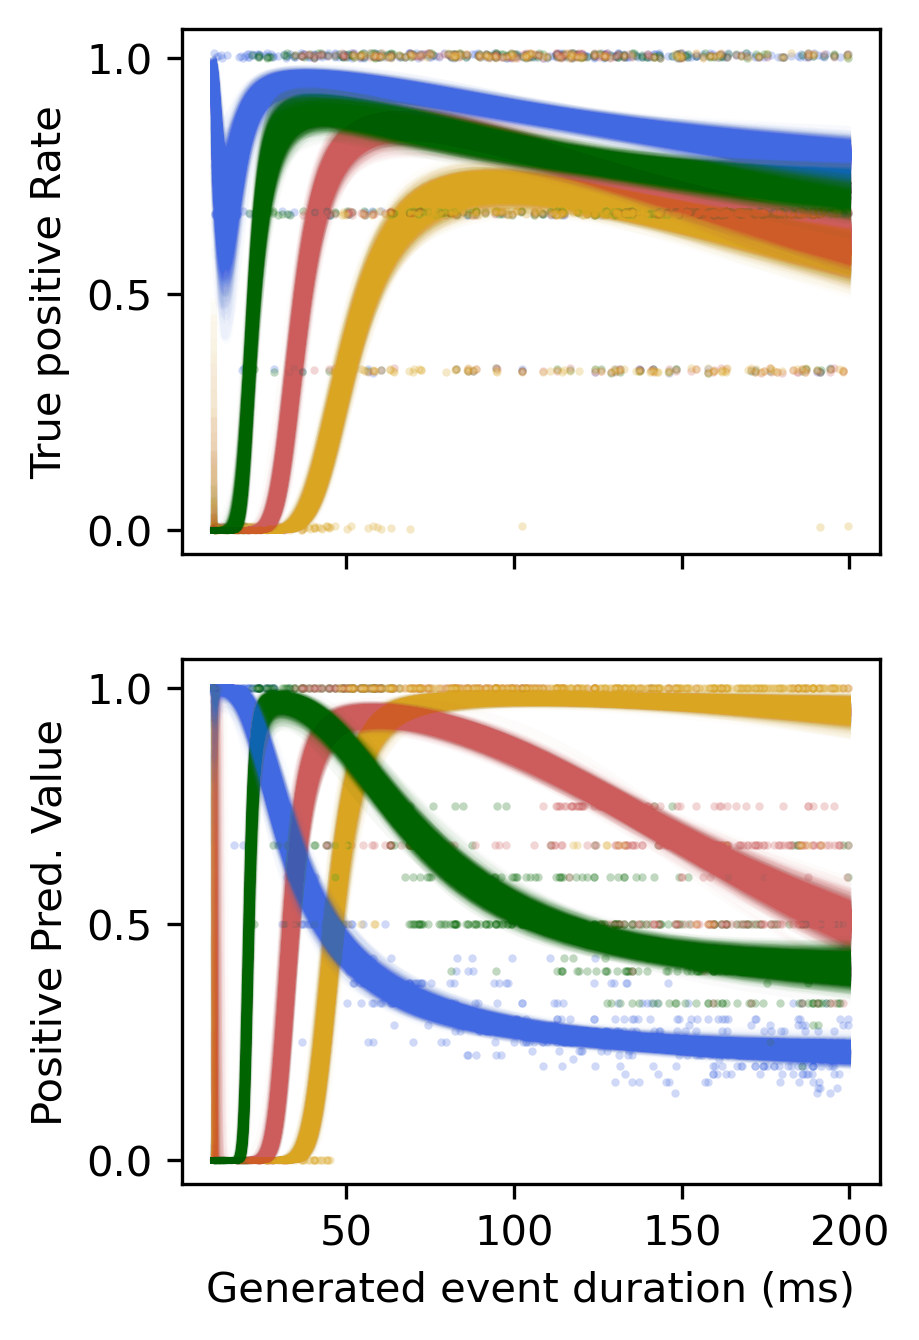

In [21]:
fig, ax = plt.subplots(2,1, dpi=300, figsize=(3,5), sharey=True, sharex=True)
colors = ['royalblue','darkgreen','indianred','goldenrod', 'pink', 'black']

for i,TestWidth in enumerate(Nevents_df.TestWidth.unique()):
    idx = new_data.index[(new_data["TestWidth"] == TestWidth)].tolist()
    ax[0].plot(1/GenWidth, tpr_posterior[idx], alpha=0.02, color=colors[i], zorder=10-i)
    subset = Nevents_df[(Nevents_df.TestWidth == TestWidth)].sort_values(by='GenWidth')
    x = subset.GenWidth
    y = subset.TPR
    ax[0].plot(1/x, y+np.random.uniform(0, 1e-2, len(x)), '.', color=colors[i], label=TestWidth, alpha=.25, mfc='w', ms=2)
    y = subset.PPV.copy()
    ax[1].plot(1/GenWidth, ppv_posterior[idx], alpha=0.02, color=colors[i], zorder=10-i)
    ax[1].plot(1/x, y, '.', color=colors[i], label=TestWidth, mfc='w', ms=2, alpha=.25)
ax[0].set_ylabel('True positive Rate')
ax[0].set_yticks([0,.5,1])
ax[1].set_ylabel('Positive Pred. Value')
ax[1].set_yticks([0,.5,1])
ax[1].set_xlabel('Generated event duration (ms)')
plt.savefig('../../plots/event_duration.png',dpi=300,transparent=True,bbox_inches='tight')

## Diagnostic checks

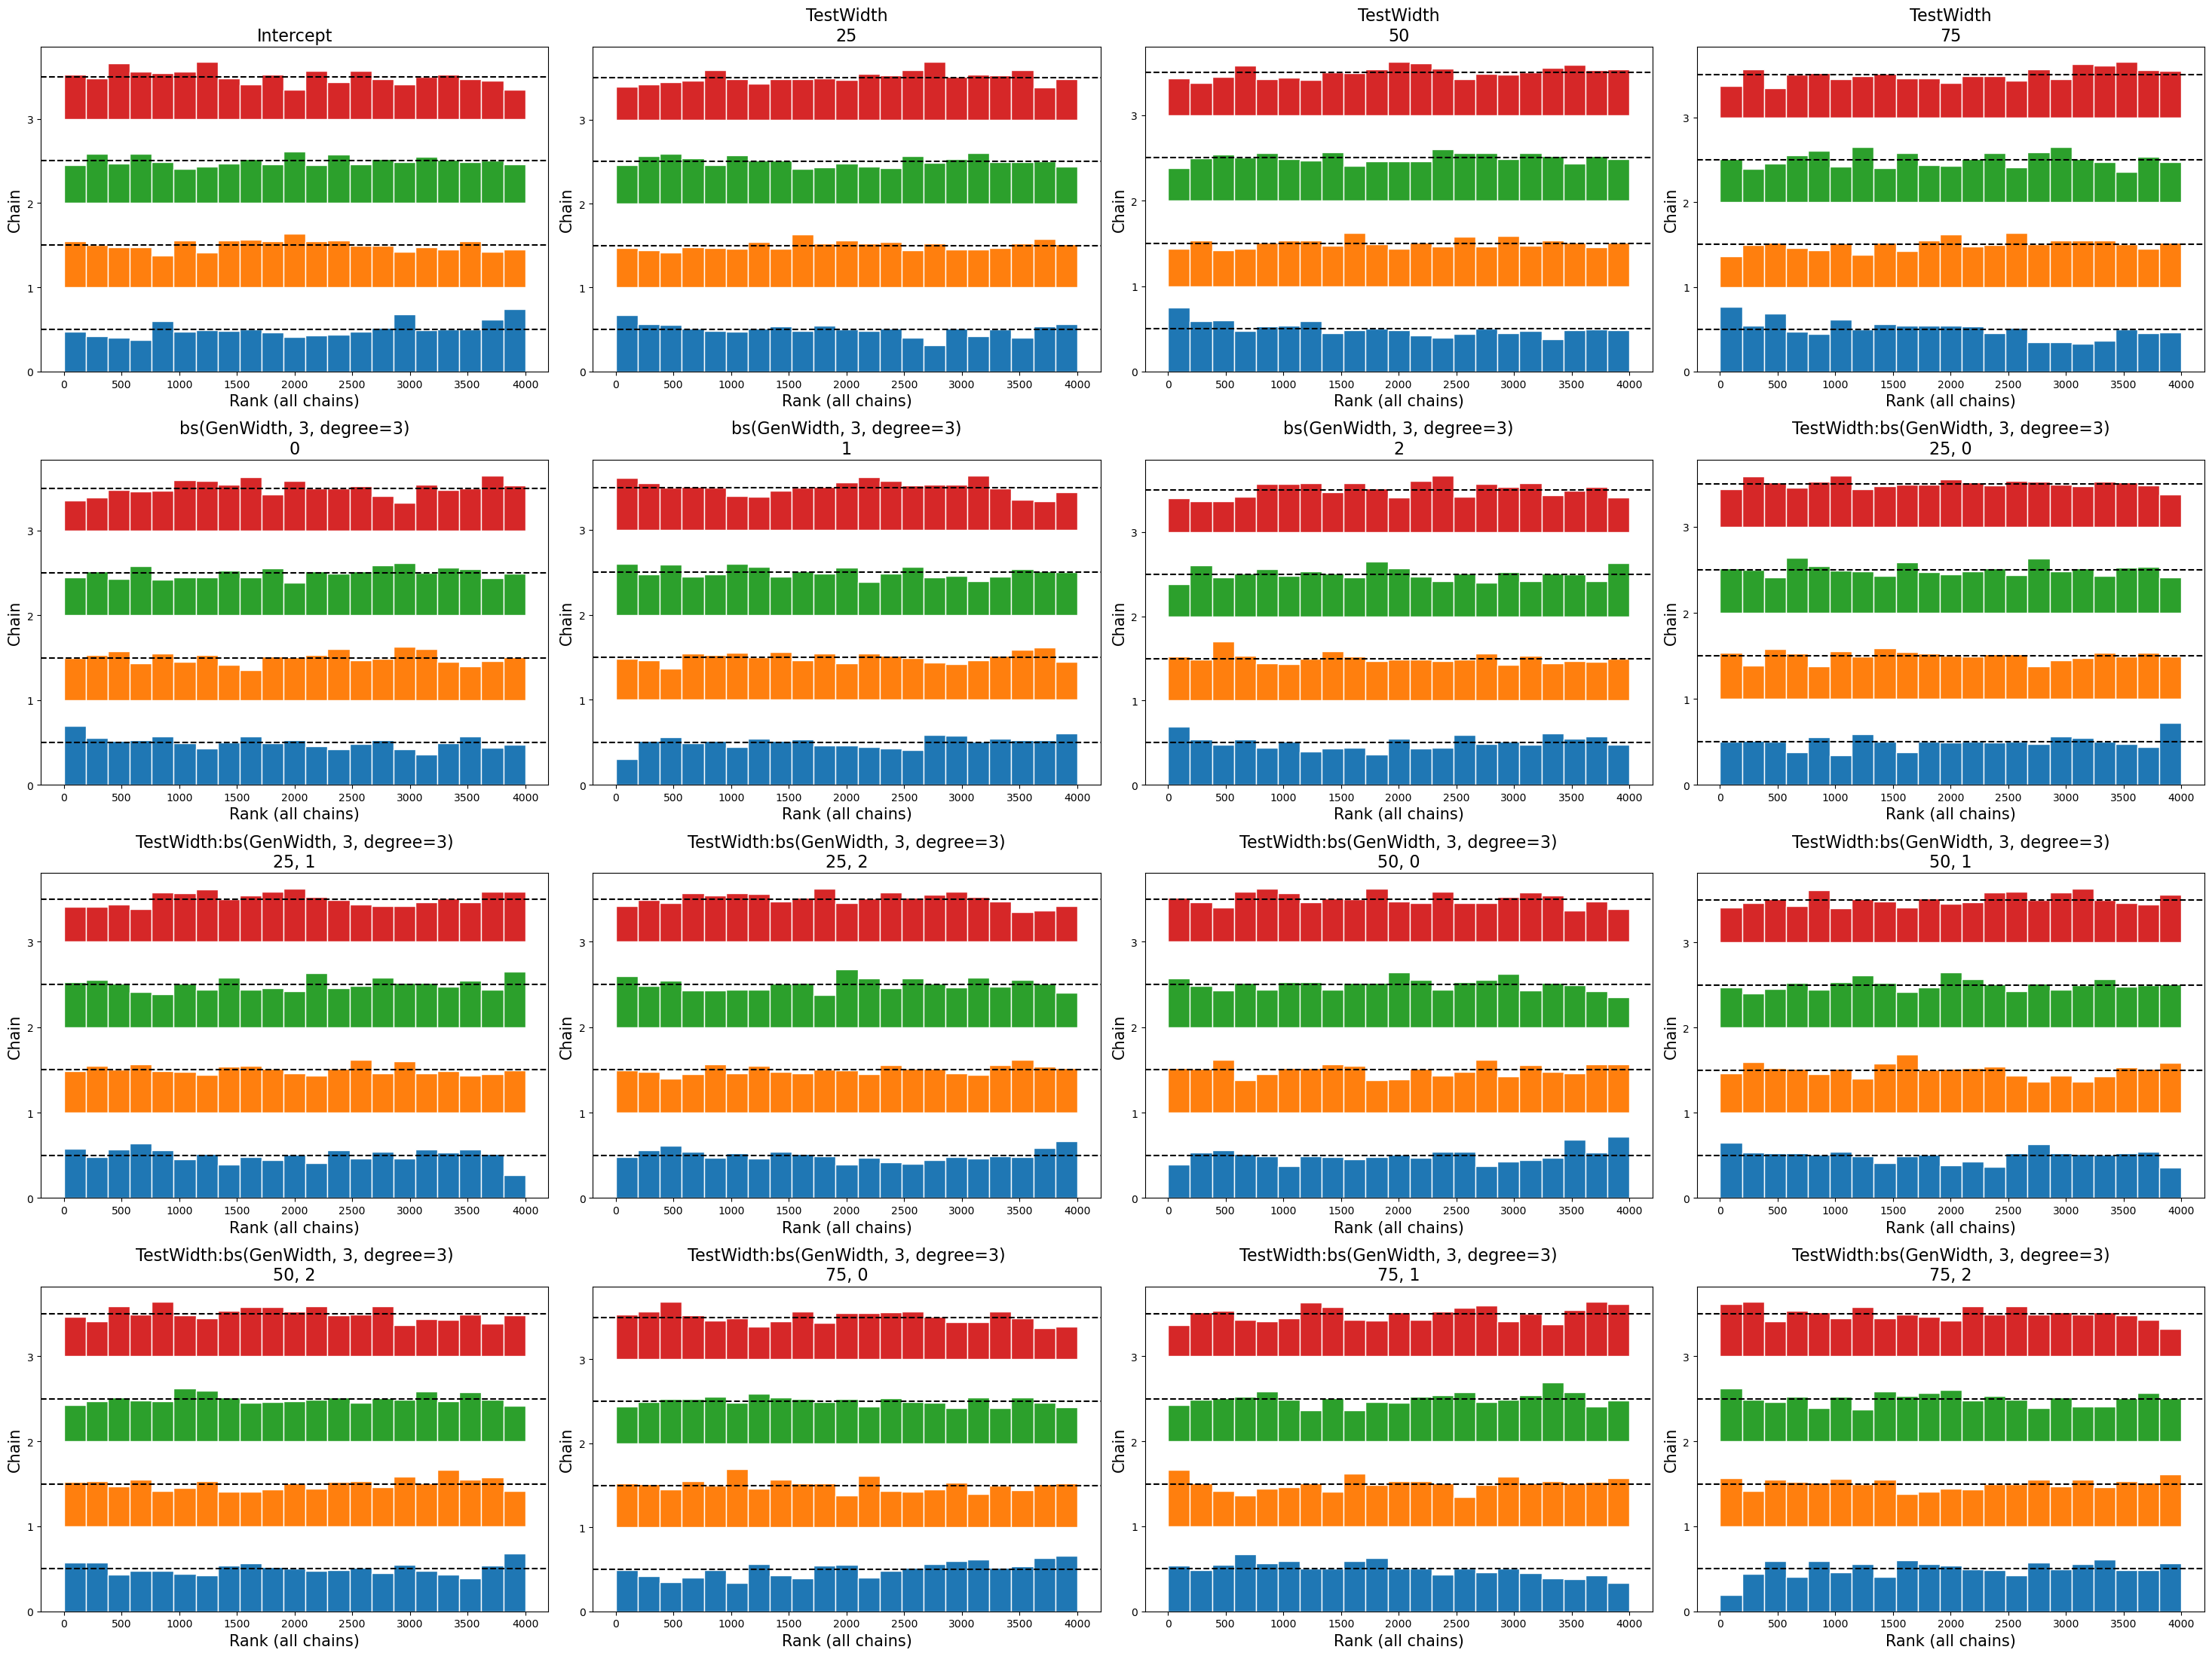

In [22]:
az.plot_rank(tpr_fit, var_names=list(list(tpr_fit.posterior.data_vars.keys()))[:-1])
plt.tight_layout()

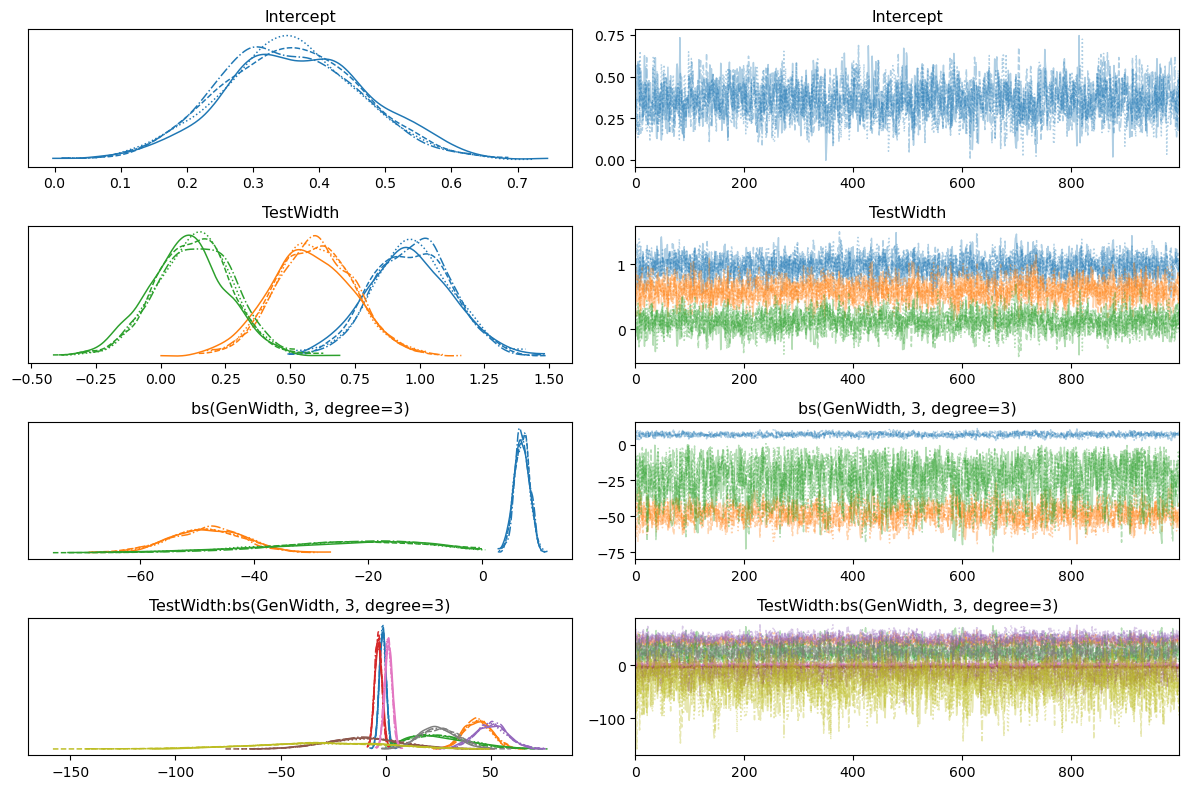

In [23]:
az.plot_trace(tpr_fit, compact=True, var_names=list(list(tpr_fit.posterior.data_vars.keys()))[:-1])
plt.tight_layout()

## Supplementary

In [24]:
az.summary(tpr_fit, hdi_prob=.95, var_names=list(list(tpr_fit.posterior.data_vars.keys()))[:-1]).iloc[:,:4].to_latex(float_format="{:0.3f}".format, bold_rows=True)

'\\begin{tabular}{lrrrr}\n\\toprule\n & mean & sd & hdi_2.5% & hdi_97.5% \\\\\n\\midrule\n\\textbf{Intercept} & 0.358 & 0.107 & 0.157 & 0.572 \\\\\n\\textbf{TestWidth[25]} & 0.969 & 0.155 & 0.677 & 1.283 \\\\\n\\textbf{TestWidth[50]} & 0.592 & 0.153 & 0.282 & 0.882 \\\\\n\\textbf{TestWidth[75]} & 0.122 & 0.150 & -0.186 & 0.397 \\\\\n\\textbf{bs(GenWidth, 3, degree=3)[0]} & 6.970 & 1.289 & 4.427 & 9.408 \\\\\n\\textbf{bs(GenWidth, 3, degree=3)[1]} & -48.261 & 6.365 & -60.878 & -35.963 \\\\\n\\textbf{bs(GenWidth, 3, degree=3)[2]} & -24.454 & 13.662 & -50.584 & -1.317 \\\\\n\\textbf{TestWidth:bs(GenWidth, 3, degree=3)[25, 0]} & -1.535 & 1.580 & -4.573 & 1.504 \\\\\n\\textbf{TestWidth:bs(GenWidth, 3, degree=3)[25, 1]} & 43.533 & 6.493 & 31.400 & 56.791 \\\\\n\\textbf{TestWidth:bs(GenWidth, 3, degree=3)[25, 2]} & 25.998 & 13.667 & 2.738 & 51.983 \\\\\n\\textbf{TestWidth:bs(GenWidth, 3, degree=3)[50, 0]} & -3.679 & 1.727 & -7.171 & -0.437 \\\\\n\\textbf{TestWidth:bs(GenWidth, 3, degree=3)[50

In [25]:
az.summary(ppv_fit, hdi_prob=.95, var_names=list(list(ppv_fit.posterior.data_vars.keys()))[:-1]).iloc[:,:4].to_latex(float_format="{:0.3f}".format, bold_rows=True)

'\\begin{tabular}{lrrrr}\n\\toprule\n & mean & sd & hdi_2.5% & hdi_97.5% \\\\\n\\midrule\n\\textbf{Intercept} & 3.057 & 0.312 & 2.485 & 3.706 \\\\\n\\textbf{TestWidth[25]} & -4.272 & 0.318 & -4.919 & -3.667 \\\\\n\\textbf{TestWidth[50]} & -3.441 & 0.321 & -4.064 & -2.812 \\\\\n\\textbf{TestWidth[75]} & -3.044 & 0.329 & -3.709 & -2.442 \\\\\n\\textbf{bs(GenWidth, 3, degree=3)[0]} & 9.813 & 2.866 & 4.208 & 15.432 \\\\\n\\textbf{bs(GenWidth, 3, degree=3)[1]} & -79.282 & 11.137 & -100.379 & -56.764 \\\\\n\\textbf{bs(GenWidth, 3, degree=3)[2]} & -33.001 & 17.847 & -67.019 & 2.316 \\\\\n\\textbf{TestWidth:bs(GenWidth, 3, degree=3)[25, 0]} & -8.321 & 2.923 & -14.153 & -2.775 \\\\\n\\textbf{TestWidth:bs(GenWidth, 3, degree=3)[25, 1]} & 85.090 & 11.373 & 64.145 & 108.207 \\\\\n\\textbf{TestWidth:bs(GenWidth, 3, degree=3)[25, 2]} & 48.322 & 19.257 & 10.902 & 85.550 \\\\\n\\textbf{TestWidth:bs(GenWidth, 3, degree=3)[50, 0]} & -8.001 & 3.013 & -13.651 & -1.931 \\\\\n\\textbf{TestWidth:bs(GenWidth,

In [26]:
tpr_model

       Formula: p(Hit, Nevents) ~ TestWidth * bs(GenWidth, 3, degree=3)
        Family: binomial
          Link: p = logit
  Observations: 1996
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.1234)
            TestWidth ~ Normal(mu: [0. 0. 0.], sigma: [5.7735 5.7735 5.7735])
            bs(GenWidth, 3, degree=3) ~ Normal(mu: [0. 0. 0.], sigma: [18.7171 26.0868 21.8105])
            TestWidth:bs(GenWidth, 3, degree=3) ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma: [26.8904
                48.1749 42.8139 26.8904 48.1749 42.8139 26.8904 48.1749 42.8139])

In [27]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Feb 13 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.21.0

matplotlib: 3.8.2
bambi     : 0.13.0
arviz     : 0.17.0
xarray    : 2024.1.1
pandas    : 2.2.0
numpy     : 1.26.4
hmp       : 0.3.0
scipy     : 1.12.0

Watermark: 2.4.3

